# Exploring Employee Referrals with Permutation Tests

## Introduction
For this notebook, the data that I am working with has 1644 observations of 'hourly' employee turnover data from a 2 year period of employees who were either referred by other employees or not. I will be exploring the question of "whether employee referrals tend to last longer on the job than non-employee referrals". 

Each observation is labeled either as an employee referral (1) or non-referral (0). The attributes I will be measureing against are whether an employee has hit or missed a milestone in their tenure at 30 days, 60 days, and 90 days. If an employee has not been hired long enough to hit a milestone, then that milestone will be a null value, otherwise it is counted as 1 for successfully hitting the milestone and 0 for failing to hit the milestone.

<b>My null hypothesis is that there is NO difference between tenure of referrals vs non-referrals.</b> 

To answer these questions, I will be using permutation tests with histograms to look at statistical significance of the initial observations. A permutation test will randomly sample and reallocate the groups of 30 60 and 90 days 1000 times to test against the actual observation. This will help to show whether the initial observations fall within the distribution that chance produced.

### Changes
List dates and brief description

08/01/2020: Initiated notebook

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import csv
import datetime
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.width = 100

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

# Data Processing
Review data and clean up columns and datatypes to prepare for analysis as needed

In [2]:
# The data was cleand and processed previous to this project

# read in the referred applicant data
file = "C:/Users/Jeff/Desktop/Projects/Data Science Portfolio/Employee Referrals/employees.csv"

# changing dtypes on attributes to handle null values
col_dtype = {'success_15': 'Int64','success_30': 'Int64','success_60': 'Int64','success_90': 'Int64'}

df = pd.read_csv(file, dtype=col_dtype)

In [3]:
# explore the quick info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   employee_num      1644 non-null   int64 
 1   hire_date         1644 non-null   object
 2   termination_date  1136 non-null   object
 3   success_15        1411 non-null   Int64 
 4   success_30        1394 non-null   Int64 
 5   success_60        1349 non-null   Int64 
 6   success_90        1247 non-null   Int64 
 7   referral          1644 non-null   int64 
dtypes: Int64(4), int64(2), object(2)
memory usage: 96.4+ KB


In [4]:
df.sample(n= 5, random_state = 42)

,employee_num,hire_date,termination_date,success_15,success_30,success_60,success_90,referral
679,26806,2019-10-04 00:00:00+00:00,NaN,1,1,1,1,0
1101,21612,2019-10-23 00:00:00+00:00,NaN,1,1,1,1,0
1516,41652,2020-03-02 00:00:00+00:00,2020-04-15 00:00:00+00:00,1,1,0,<NA>,0
1403,28534,2019-10-23 00:00:00+00:00,2020-01-29 00:00:00+00:00,1,1,1,1,0
660,25523,2019-09-04 00:00:00+00:00,2019-09-04 00:00:00+00:00,<NA>,<NA>,<NA>,<NA>,0


In [5]:
# let's get the time sample using "dbCreated"
new_earliest_date = df['hire_date'].min()
new_recent_date = df['hire_date'].max()

print("Time sample start: " + str(new_earliest_date))
print("Time sample end: " + str(new_recent_date))
print()
print()

print("Referrals:\n0 = not referred\n1 = referred")
df['referral'].value_counts()


Time sample start: 2018-04-12 00:00:00+00:00
Time sample end: 2020-05-27 00:00:00+00:00


Referrals:
0 = not referred
1 = referred


0    1211
1     433
Name: referral, dtype: int64

## Functions

Here are the functions that I will be using in the analysis

In [6]:
import random

def perm_fun(df,A_n,B_n):
    ''' This function randomly resamples from the group and returns the difference in means'''
    
    N = A_n + B_n 
    idx_B = set(random.sample(range(N),B_n)) # pull new random sample from N with length B_n
    idx_A = set(range(N))- idx_B # create new sample for A_n by subtracting idx_B from N
    return df.loc[idx_B].mean() - df.loc[idx_A].mean() # return the difference in means

def actual_obs(df,success):
    ''' This function creates a crosstab of the actual milestone observations 
    and returns the means and the mean difference '''
    
    idx = pd.IndexSlice
    i = pd.crosstab(df['referral'],success,margins=True, margins_name="Total")
    print()
    print(i.to_markdown())
    print()
    A = (i.loc[idx[0,1]]) # this is the non-referral count of success for the success milestone
    A_n = (i.loc[idx[0,'Total']]) # this is the n of non-referrals
    B = (i.loc[idx[1,1]]) # this is the referral count of success for the success milestone
    B_n = (i.loc[idx[1,'Total']]) # this is the n of referrals
    percent_succ_ref = A / A_n
    percent_succ_non = B / B_n
    mean_diff = (percent_succ_non - percent_succ_ref)
    print()
    print(f"Observed Success of total referred: {(percent_succ_ref):.04%}")
    print(f"Observed Success of total non_referred: {(percent_succ_non):.04%}")
    print(f"Difference in observed means: {(mean_diff):.04}")
    print()
    print()
    return A_n, B_n, mean_diff

def perm_plot(perm_diffs,mean_diff):
    ''' This function plots the histogram of the permutation test'''
    
    fig,ax = plt.subplots(figsize = (10,7))
    ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
    ax.axvline(x = mean_diff,linestyle = 'dashed', color = 'red', lw = 2)
    ax.text(mean_diff,200,'Observed\ndifference',fontsize = 14)#, bbox = {'facecolor':'white'})
    ax.set_xlabel('Differences in Means',fontsize = 14)
    ax.set_ylabel('Frequency',fontsize = 14)
    sns.despine()
    

# Analysis/Modeling

## Referred vs Non-referred: actual observations
Here we will be measuring who was referred and succeeded vs who was not referred and succeeded

The question that we want to test for is whether these outcomes are more different than what may be generated by chance. So I will be looking to see if through modeling of the data by using a permutation test, what the probability is that I can obtain results as extreme as the actual observed results in the data.

## Permutation Test

Here, I will be running permutation tests 1000 times each for each of the 3 milestone groups to create a random distribution of the means that will be plotted as a histogram. For each test, I will be plotting the actual observed mean difference with a red line to visually display where the actual observation lands within the distribution of random permutations of the data.

### Success at 30 Days


| referral   |   0 |   1 |   Total |
|:-----------|----:|----:|--------:|
| 0          | 381 | 627 |    1008 |
| 1          | 140 | 246 |     386 |
| Total      | 521 | 873 |    1394 |


Observed Success of total referred: 62.2024%
Observed Success of total non_referred: 63.7306%
Difference in observed means: 0.01528



Average amount random chance is greater than observed: 0.307


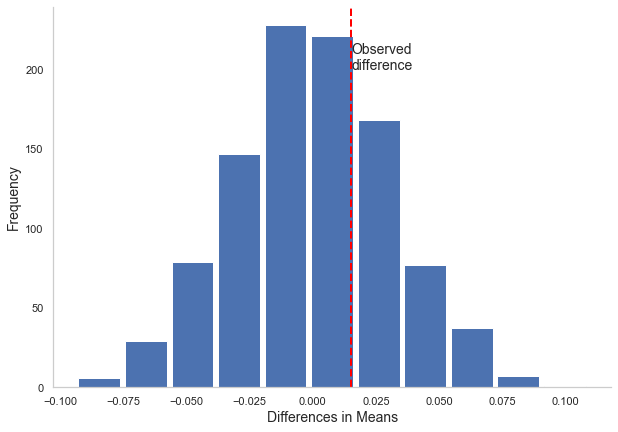

In [7]:
success = df.success_30

A_n,B_n,mean_diff = actual_obs(df,success)
perm_diffs = [perm_fun(success,A_n,B_n) for _ in range(1000)]
perm_plot(perm_diffs,mean_diff)
print()
prob = np.mean(perm_diffs > mean_diff)
print(f"Average amount random chance is greater than observed: {prob}")

Above: From the random permutation test, the initial observation of the mean difference between the referrals and non-referrals is exceeded by 30% of the distribution. Thus we can say that the observation is NOT statistically significant and we fail to reject the null hypothesis.

### Success at 60 Days


| referral   |   0 |   1 |   Total |
|:-----------|----:|----:|--------:|
| 0          | 535 | 441 |     976 |
| 1          | 170 | 203 |     373 |
| Total      | 705 | 644 |    1349 |


Observed Success of total referred: 45.1844%
Observed Success of total non_referred: 54.4236%
Difference in observed means: 0.09239



Average amount random chance is greater than observed: 0.005


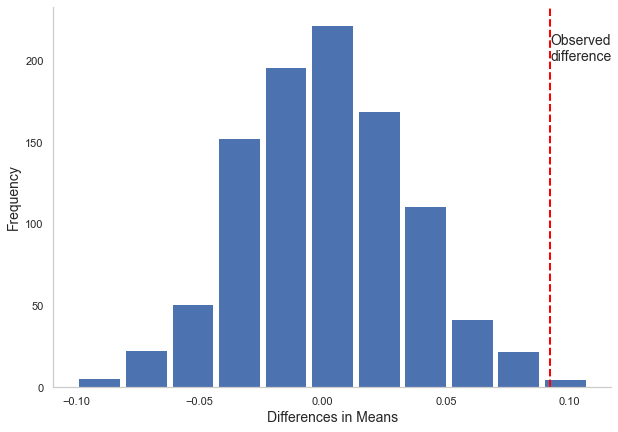

In [8]:
success = df.success_60


A_n,B_n,mean_diff = actual_obs(df,success)
perm_diffs = [perm_fun(success,A_n,B_n) for _ in range(1000)]
perm_plot(perm_diffs,mean_diff)
print()
prob = np.mean(perm_diffs > mean_diff)
print(f"Average amount random chance is greater than observed: {prob}")

Above: From the random permutation test, the initial observation of the mean difference between the referrals and non-referrals at the 60 day milestone exceeds the range of chance variation approximately 99% of the time. Thus we can say that the observation IS statistically significant and we can reject the null hypothesis

### Success at 90 Days


| referral   |   0 |   1 |   Total |
|:-----------|----:|----:|--------:|
| 0          | 595 | 314 |     909 |
| 1          | 195 | 143 |     338 |
| Total      | 790 | 457 |    1247 |


Observed Success of total referred: 34.5435%
Observed Success of total non_referred: 42.3077%
Difference in observed means: 0.07764



Average amount random chance is greater than observed: 0.012


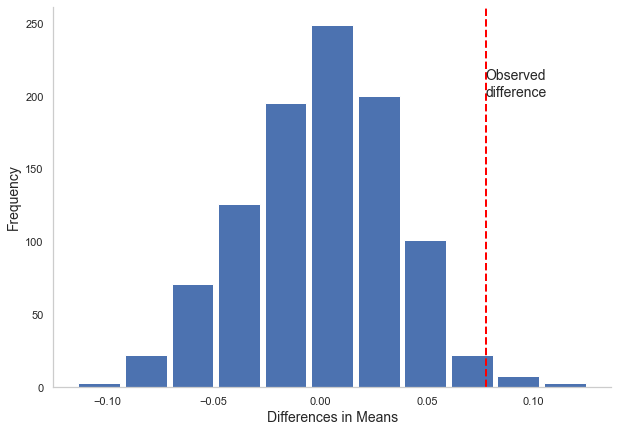

In [9]:
success = df.success_90


A_n,B_n,mean_diff = actual_obs(df,success)
perm_diffs = [perm_fun(success,A_n,B_n) for _ in range(1000)]
perm_plot(perm_diffs,mean_diff)
print()
prob = np.mean(perm_diffs > mean_diff)
print(f"Average amount random chance is greater than observed: {prob}")

 Above: From the random permutation test, our initial observation of the mean difference between the referrals and non-referrals at the 90 day mileston exceeds the range of chance variation approximately 99% of the time. Thus we can say that the observation IS statistically significant and we can reject the null hypothesis

# Conclusions

From the experiment that was conducted, I did not see any real difference at 30 days from the effect of referrals over non-referrals. However, at the 60 and 90 day milestones, the observed differences between referred employees and non-referred employess showed a statistically significant difference between referrals and non-referrals. These findings from the data may suggest that referred employees tend to last longer on the job than non-referred employees. <br>

While the finding is statistically significant, the effect of referrals from 60 and 90 days is still less than a 10% difference. However, this knowledge should inform the recruiters and hiring managers to encourage current employees to refer candidates for jobs as reducing employee turnover can create savings both in costs associated with recruitment and training as well as cutting down on lost productivity due to employee attrition. 